In [12]:
#The goal of this notebook is to calculate the energy from the csv 
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/home/brantran/power_modeling/accel-sim-framework'

In [3]:
#Step one is to read in the csvs
#Oh dear, we have a frequency of 46c (which is 1132 in hex)
#Alright, so we know that we are sampling every 500 cycles
#Frequency would then be defined as cycles per second
def convert_to_decimal(val):
    try:
        # Attempt to convert directly to integer (for normal numeric values)
        return int(val)
    except ValueError:
        try:
            # If the conversion fails, assume it's hexadecimal and convert
            return int(val, 16)
        except ValueError:
            # Handle any other unexpected values
            return None


accelwattch_dir = os.path.join('logs_accelwattch','100iter_perkernel_sample_500cycle')
kernel_info_list = []
bad_freq_list = []
for file in os.listdir(accelwattch_dir)[15:]:
    file_path = os.path.join(accelwattch_dir,file)
    df = pd.read_csv(file_path)    
    # Apply the function to the 'core_clock_freq_mhz' column
    df['core_clock_freq_mhz'] = df['core_clock_freq_mhz'].apply(convert_to_decimal)
    #Parse the file names
    benchmark,details = file.split('.accelsim-commit-5b72768d4f64cb46b91dc9556dbe04298cdff5d8_modified_5.0_processed_')
    kernel,cycle_count,instr_count = details.strip('.csv').split('_')
#     print(benchmark,kernel,cycle_count,instr_count)

    core_clock = list(df.core_clock_freq_mhz)
    for val in core_clock:
        try:
            good_val = int(val)
        except:
            if benchmark+val not in bad_freq_list:
                print(benchmark,val)
                bad_freq_list.append(benchmark+val)

    #Append all the information to the list
    kernel_info_list.append((benchmark,kernel,
                             int(cycle_count.strip('cycle')),int(instr_count.strip('instr')),
                             df))
            
#     break
kernel_info_list.sort(key=lambda x: x[0])
# list(df.core_clock_freq_mhz)
# kernel_info_list
# df

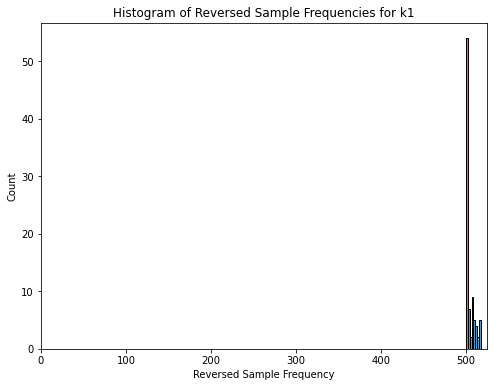

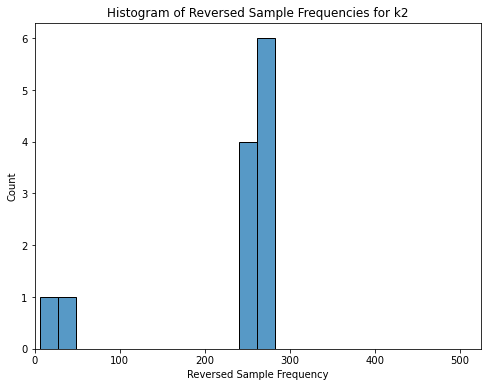

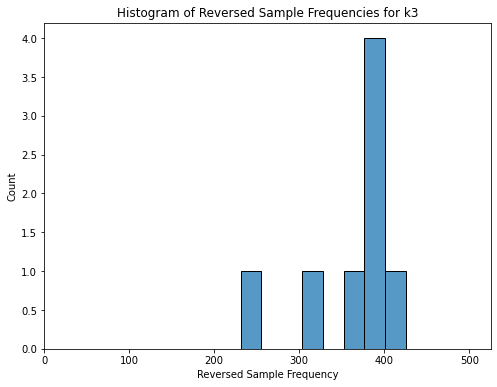

In [9]:
#SANITY CHECKING
# Question: 500 cycle sample * num_samples ~ total_cycles?
# Answer: For kernel_1 this is relatively true
#     for all other kernels the sampling rate appears to be 200-400
cycles_per_sample = 500
for kernel_info in kernel_info_list:
    benchmark,kernel,cycle_count,instr_count,df = kernel_info
#     print(f"""{benchmark}_{kernel} sampled {len(df)}
#     Calculated total={len(df)*cycles_per_sample}
#     Expected total  ={cycle_count}
#     Reversed sample frequency = {int(cycle_count/len(df))}
#     """)

# Dictionary to collect reversed sample frequencies for each kernel
reversed_freq_by_kernel_dict = {}
reversed_freq_dict = {}
# Process each kernel_info in the list
for benchmark, kernel, cycle_count, instr_count, df in kernel_info_list:
    reversed_sample_freq = int(cycle_count / len(df))
    
    # Collect the reversed sample frequency for the kernel
    if kernel not in reversed_freq_by_kernel_dict:
        reversed_freq_by_kernel_dict[kernel] = []
    reversed_freq_by_kernel_dict[kernel].append(reversed_sample_freq)
    reversed_freq_dict[benchmark+kernel]=reversed_sample_freq
    

# Plot histograms for each kernel group
for kernel, freqs in reversed_freq_by_kernel_dict.items():
    plt.figure(figsize=(8, 6))
    sns.histplot(freqs)
    plt.title(f'Histogram of Reversed Sample Frequencies for {kernel}')
    plt.xlim(0,525)
    plt.xlabel('Reversed Sample Frequency')
    plt.ylabel('Count')
    plt.show()

In [38]:
#SANITY CHECK:
# Question: Are the simulated instructions matched with actual execution?
# Answer: For setup kernels okay, but for actual kernels we are an order of magnitude off
#     We are simulating way more instructions than were actually executed
#     Does the simulated count include predicated instructions
!python3 ../flop_counting/parse_ncu_report.py ../flop_counting/ncu_reports/ncu_report_accelwattch_for_matt_100/

BE_L2D_HIT_100-k1 = l2_pointers_init: 1
BE_L2D_HIT_100-k2 = l2_stress: 1
BE_MEM_SHRD_Acss_100-k1 = PowerKernal2: 1
BE_SP_FP_MUL_100-k1 = PowerKernal2: 1
BE_SP_INT_MUL32_100-k1 = PowerKernal3: 1
BE_SP_FP_MAD_100-k1 = PowerKernal2: 1
BE_MEM_DRAM_Acss_10-k1 = PowerKernal2: 1
BE_SP_FP_ADD_100-k1 = PowerKernal1: 1
BE_L1D_HIT_100-k1 = l1_pointers_init: 1
BE_L1D_HIT_100-k2 = l1_stress: 1
BE_SP_INT_ADD_100-k1 = PowerKernal2: 1
All data written out to ../flop_counting/ncu_reports/ncu_report_accelwattch_for_matt_100/all_benchmark_sass__inst_executed_per_opcode_with_modifier_all.csv


In [50]:
instr_data = pd.read_csv('../flop_counting/ncu_reports/ncu_report_accelwattch_for_matt_100/all_benchmark_sass__inst_executed_per_opcode_with_modifier_all.csv')
instr_data.set_index('benchmark',inplace=True)
instr_data['total'] = instr_data.sum(axis=1)
ground_truth_instr_count_dict = instr_data['total'].to_dict()

for benchmark,kernel,cycle_count,instr_count,df in kernel_info_list:
    key = f"{benchmark}_{kernel}".replace('-','_')
    if key in ground_truth_instr_count_dict:
        ground_truth = ground_truth_instr_count_dict[key]
        print(f"""{key}
        Simulated:    {instr_count}
        Ground Truth: {ground_truth}
        MAPE:         {100*abs(instr_count - ground_truth)/ground_truth:2f}%
        """)
#     else:
#         print("Not in dict", key)
#     print(f"""{benchmark}_{kernel} sampled {len(df)}
#     Calculated total={len(df)*cycles_per_sample}
#     Expected total  ={cycle_count}
#     Reversed sample frequency = {int(cycle_count/len(df))}
#     """)

BE_L1D_HIT_100_k1
        Simulated:    1058087
        Ground Truth: 1058410.0
        MAPE:         0.030517%
        
BE_L1D_HIT_100_k2
        Simulated:    20807680
        Ground Truth: 814080.0
        MAPE:         2455.974843%
        
BE_L2D_HIT_100_k1
        Simulated:    1058087
        Ground Truth: 1058410.0
        MAPE:         0.030517%
        
BE_L2D_HIT_100_k2
        Simulated:    20807680
        Ground Truth: 814080.0
        MAPE:         2455.974843%
        
BE_MEM_DRAM_Acss_10_k1
        Simulated:    653393920
        Ground Truth: 20746240.0
        MAPE:         3049.457058%
        
BE_MEM_SHRD_Acss_100_k1
        Simulated:    37847040
        Ground Truth: 1346560.0
        MAPE:         2710.646388%
        
BE_SP_FP_ADD_100_k1
        Simulated:    54886400
        Ground Truth: 1868800.0
        MAPE:         2836.986301%
        
BE_SP_FP_MAD_100_k1
        Simulated:    103383040
        Ground Truth: 3389440.0
        MAPE:         2950.151057%
 

In [54]:
# Calculate the total energy
# We use the static power of 32W
# We integrate our power samples over derived time (from frequency and cycles per sample)
# Since we are simulating 100 iters, runtime is very short, so we expect low energy
energy_dict = {}
plotting_dict = {}


static_power=32.32522272

for benchmark, kernel, cycle_count, instr_count, df in kernel_info_list:
    # Define the processor frequency (in MHz)
    df['cycles_per_second'] = df['core_clock_freq_mhz'] * 10**6
    df['cycle_duration'] = df['cycles_per_second'].rdiv(1)
    df['sample_duration'] = df['cycle_duration'] * reversed_freq_dict[benchmark+kernel]    
    dyn_energy = np.trapz(df['runtime_dynamic_W'], x=df['sample_duration'].cumsum())
    static_power_resized = np.resize(static_power, len(df))
    static_energy = np.trapz(static_power_resized, x=df['sample_duration'].cumsum())
    total_energy = dyn_energy + static_energy
    energy_dict[benchmark]=(total_energy,dyn_energy,static_energy,cycle_count)
    plotting_dict[benchmark]=df['runtime_dynamic_W'] + static_power_resized

# Unpack the tuples into separate lists
data = [(benchmark, *values) for benchmark, values in energy_dict.items()]

# Create a DataFrame
energy_df = pd.DataFrame(data, columns=['benchmark', 'total_energy_J', 'dyn_energy_J', 'static_energy_J', 'cycles'])
# energy_df.to_csv(f'{target_dir}_energy.csv',index=False)
energy_df

,benchmark,total_energy_J,dyn_energy_J,static_energy_J,cycles
0,ACT_CORE1-100_16_32,0.000413,0.000192,0.000221,8280
1,ACT_CORE1-100_1_32,0.000377,0.000159,0.000218,8168
2,ACT_CORE1-100_32_32,0.000458,0.000228,0.000230,8555
3,ACT_CORE1-100_48_32,0.000487,0.000258,0.000229,8522
4,ACT_CORE1-100_64_32,0.000517,0.000289,0.000228,8514
...,...,...,...,...,...
83,mix4-100,0.047181,0.033303,0.013878,486727
84,mix5-100,0.047729,0.033009,0.014721,516095
85,mix8-100,0.041727,0.029577,0.012151,426311
86,mix9-100,0.055963,0.038273,0.017690,620254


In [55]:
#This would be trying to write out the data as a csv
#Holding off for now

# target_dirs = ['100iter_sample_per_500cycle','10iter_processed']
# total_df = None
# for target_dir in target_dirs:
#     target_file = f'{target_dir}_energy.csv'
#     if total_df is None:
#         total_df = pd.read_csv(target_file)
#     else:
#         new_df = pd.read_csv(target_file)
#         total_df = total_df.merge(new_df, on="benchmark", suffixes=('', target_dir.split("iter")[0]))
# total_df.to_csv(f'accelwattch_energy.csv',index=False)

In [56]:
plotting_dict.keys()

dict_keys(['ACT_CORE1-100_16_32', 'ACT_CORE1-100_1_32', 'ACT_CORE1-100_32_32', 'ACT_CORE1-100_48_32', 'ACT_CORE1-100_64_32', 'ACT_CORE1-100_80_32', 'ACT_CORE2-100_16_32', 'ACT_CORE2-100_1_32', 'ACT_CORE2-100_32_32', 'ACT_CORE2-100_48_32', 'ACT_CORE2-100_64_32', 'BE_DP_FP_ADD-100', 'BE_DP_FP_DIV-100', 'BE_DP_FP_MAD-100', 'BE_DP_FP_MUL-100', 'BE_HP_FP_ADD-100', 'BE_HP_FP_DIV-100', 'BE_HP_FP_MAD-100', 'BE_HP_FP_MUL-100', 'BE_L1D_HIT-100', 'BE_L2D_HIT-100', 'BE_MEM_DRAM_Acss-10', 'BE_MEM_SHRD_Acss-100', 'BE_SFU_EXP-100', 'BE_SFU_LG2-100', 'BE_SFU_SQRT-100', 'BE_SP_FP_ADD-100', 'BE_SP_FP_DIV-100', 'BE_SP_FP_MAD-100', 'BE_SP_INT_DIV-100', 'BE_SP_INT_LOGIC-100', 'BE_SP_INT_MUL-100', 'BE_SP_INT_MUL32-100', 'BE_TEXTURE_ACCESS-100', 'BRANCHING1-100', 'BRANCHING3-100', 'BRANCHING4-100', 'BRANCHING5-100', 'INT_FP_DP_STATIC-100_80_1', 'INT_FP_DP_STATIC-100_80_16', 'INT_FP_DP_STATIC-100_80_32', 'INT_FP_DP_STATIC-100_80_8', 'INT_FP_SFU_STATIC-100_80_1', 'INT_FP_SFU_STATIC-100_80_16', 'INT_FP_SFU_STAT

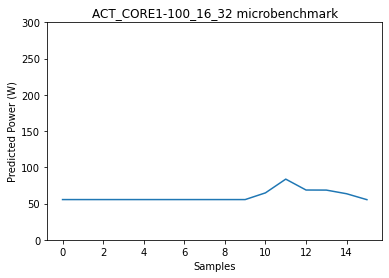

83.70672272


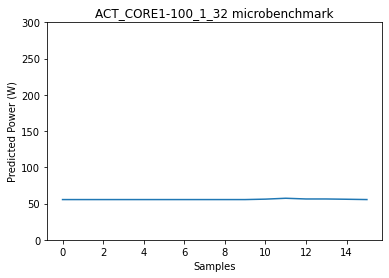

57.315222719999994


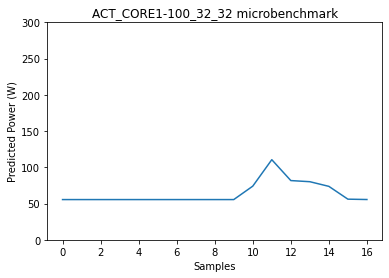

110.52732272


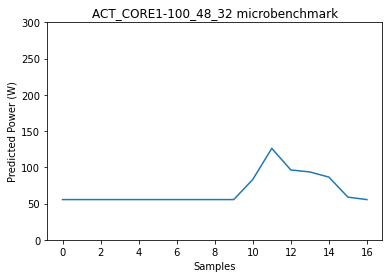

126.15152272


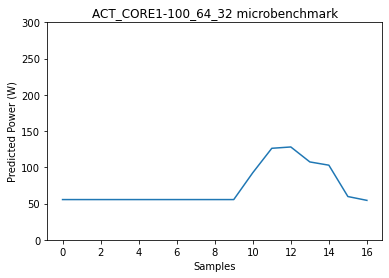

128.08332272


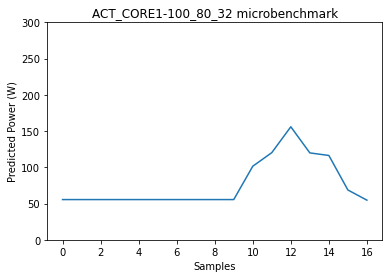

155.92322272


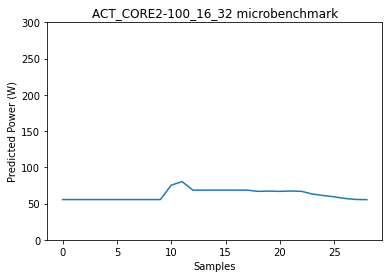

80.28132271999999


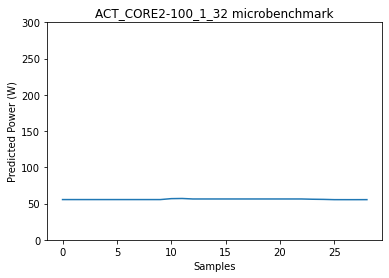

57.00262272


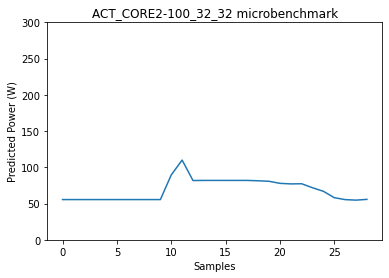

109.99412272


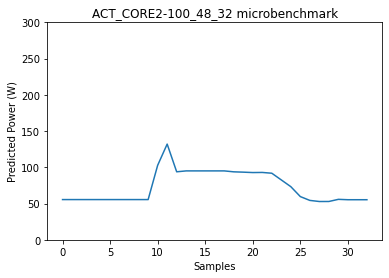

132.03722272


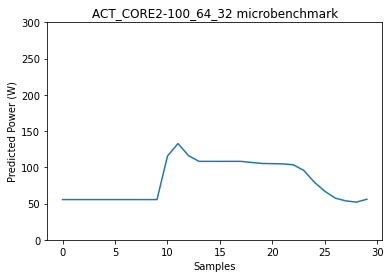

132.82422272


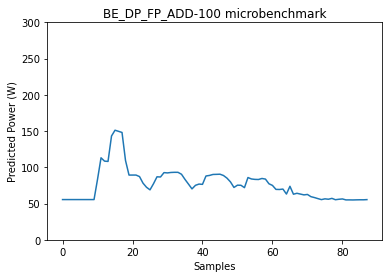

151.18722272


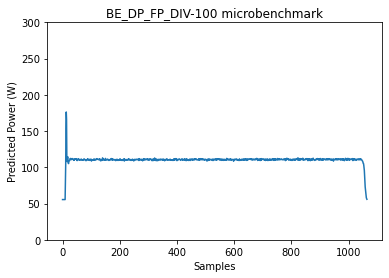

176.35122272


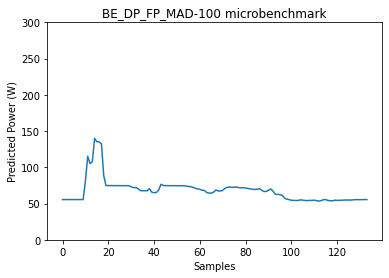

139.88622272


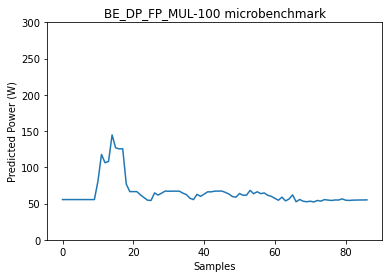

144.68922272


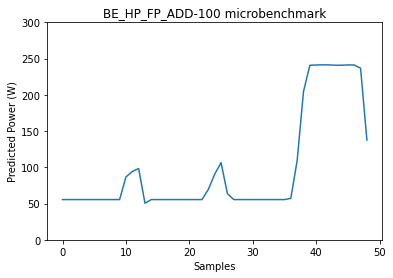

241.39122272


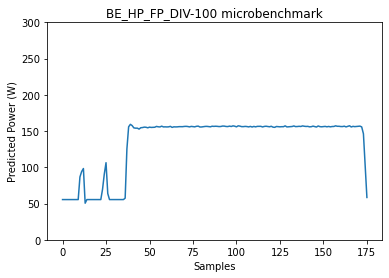

159.29022272


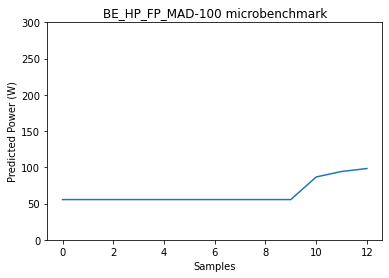

98.32642272


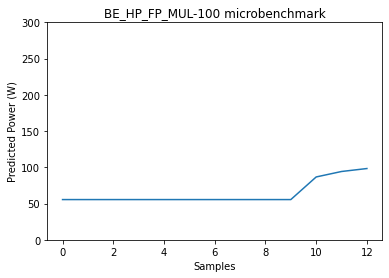

98.32642272


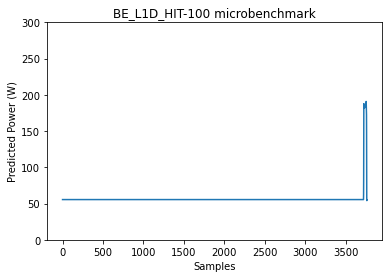

190.86122272


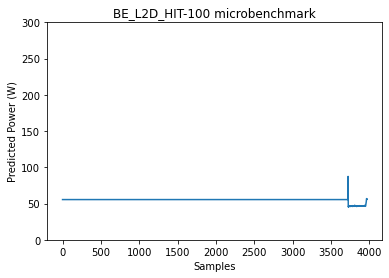

87.42432271999999


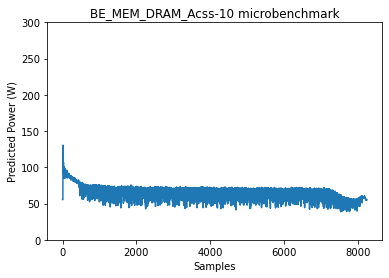

130.53902272


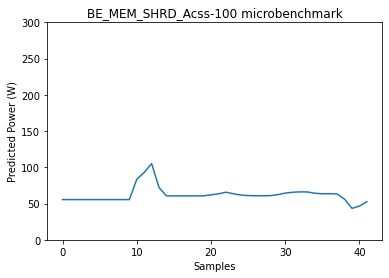

105.12942272


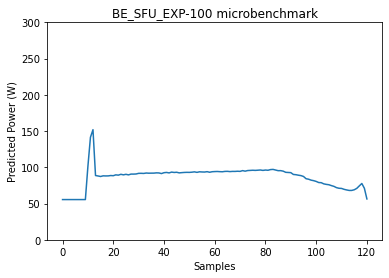

151.93122272


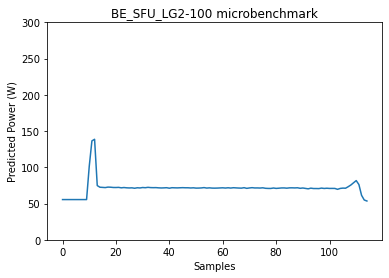

138.70022272


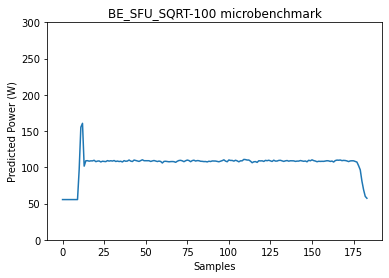

160.71022272


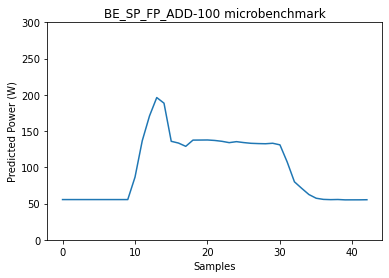

196.24422272


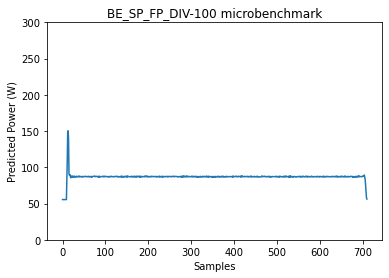

150.40222272


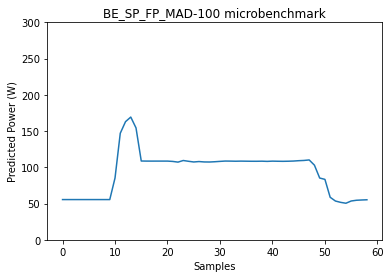

169.32722272


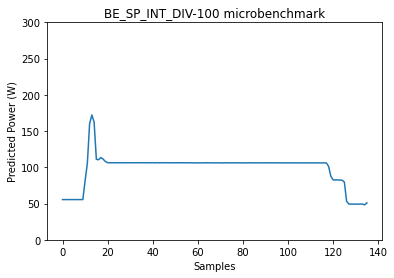

172.19922272


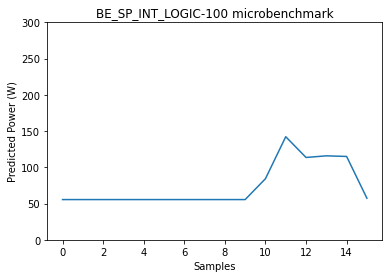

142.21522271999999


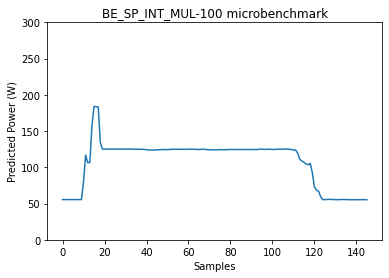

184.17422272


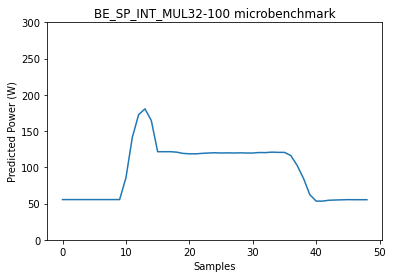

180.68722272


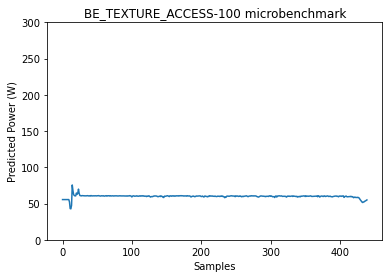

75.66462272


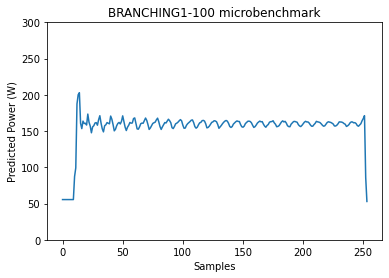

202.94322272


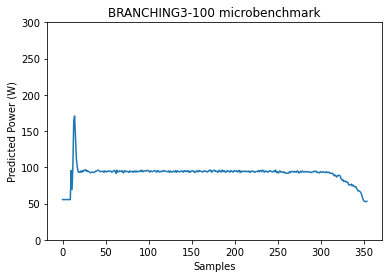

170.83722272


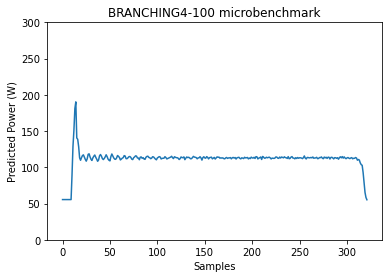

190.29622272


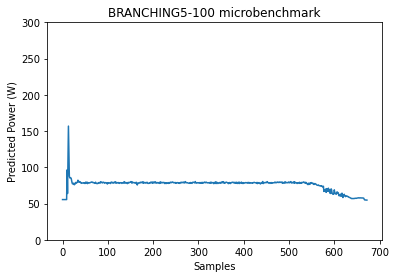

156.88122271999998


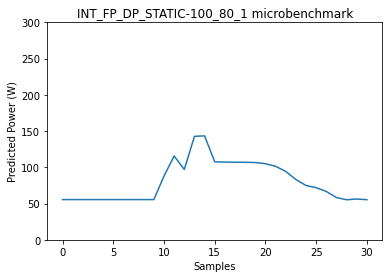

143.37422272


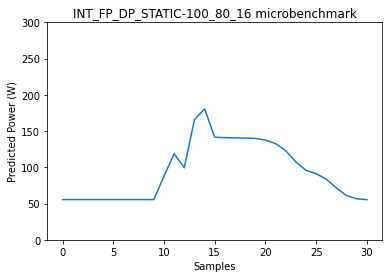

180.63022272


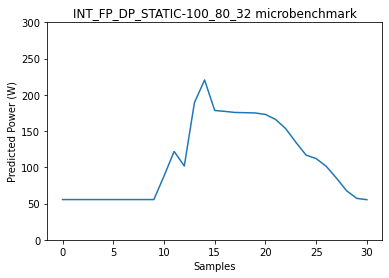

220.50122272


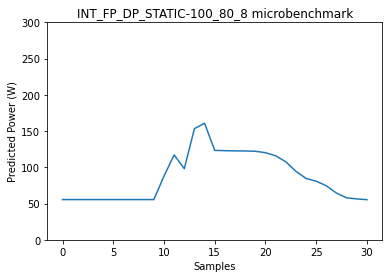

160.76022272


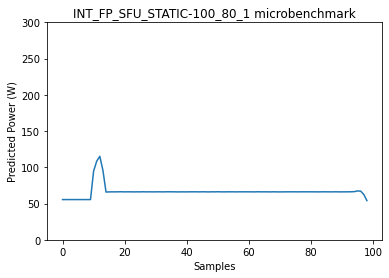

115.20322272


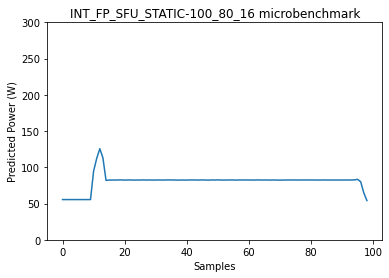

125.68722272


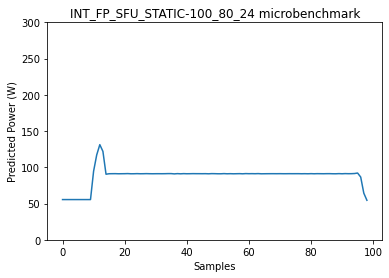

131.27002272


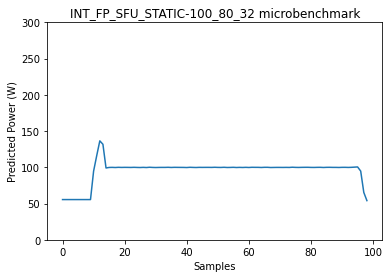

136.49322272


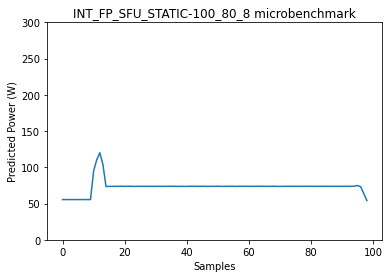

120.09582272


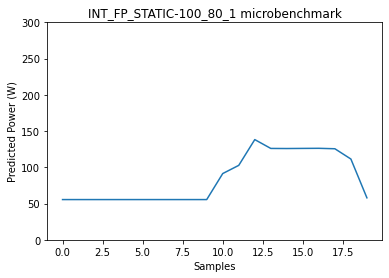

138.25522272


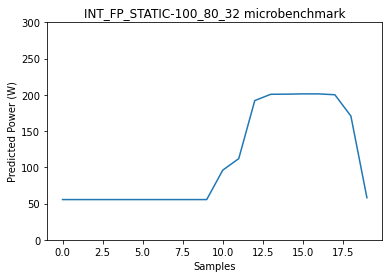

201.33322272


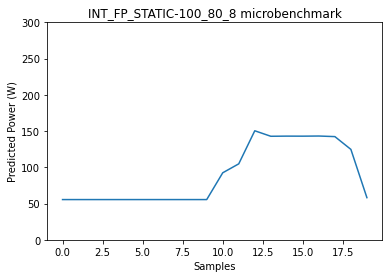

150.41722271999998


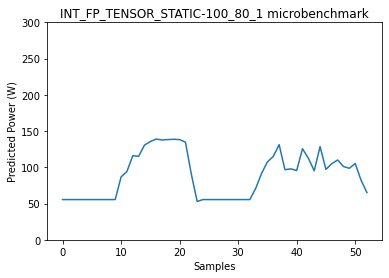

138.98722272


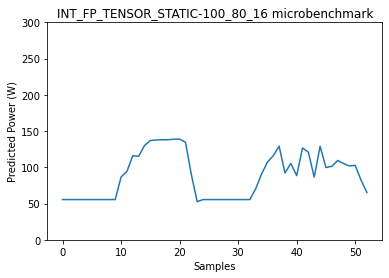

138.99022272000002


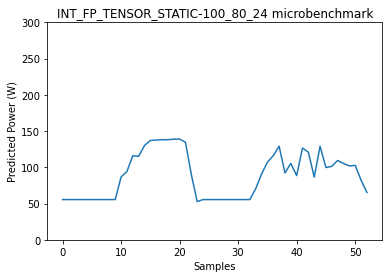

138.99022272000002


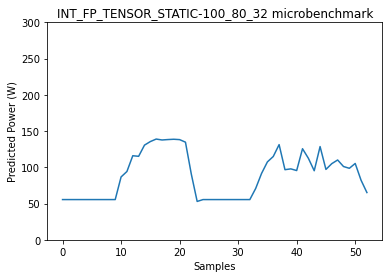

138.98722272


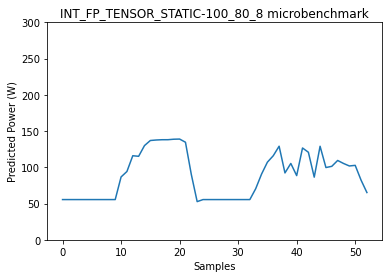

138.99022272000002


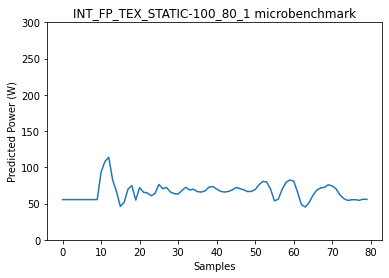

113.83842272


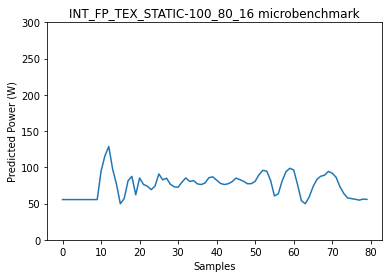

128.72802272


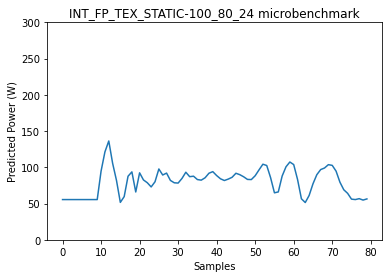

136.33822272


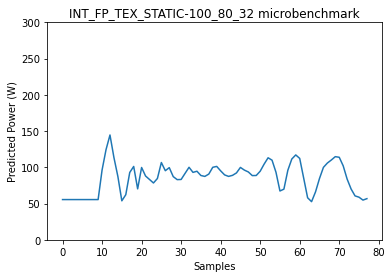

144.60722271999998


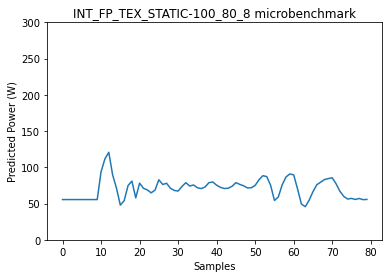

120.79102272


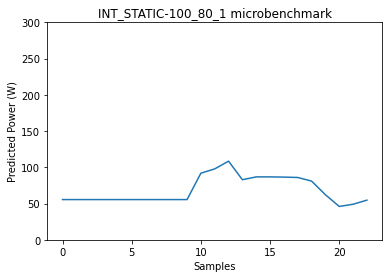

108.48882272


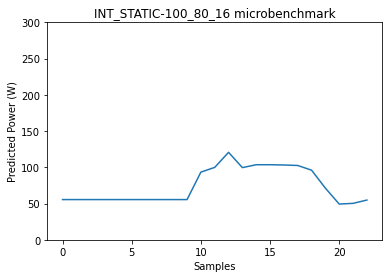

120.68992272


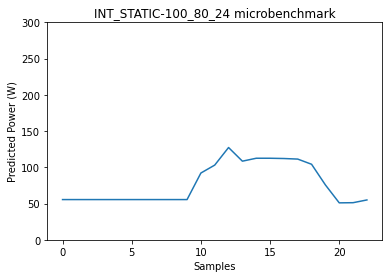

127.31402272


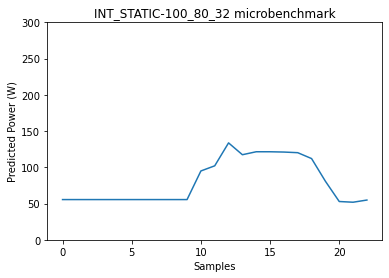

133.70522272


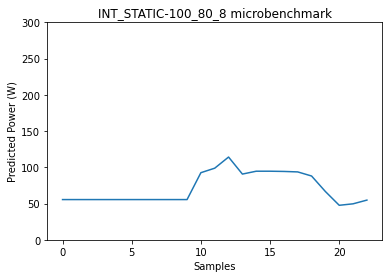

114.18262272


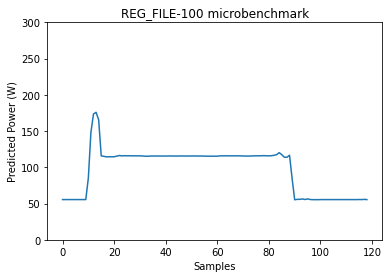

175.88322272


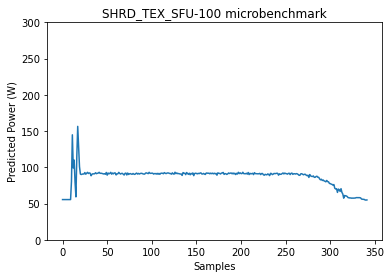

156.49022272000002


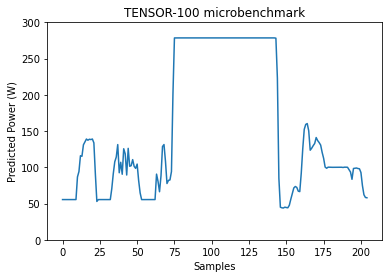

278.55622272


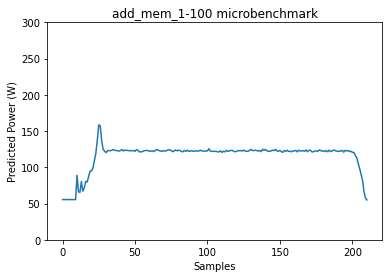

158.67122272


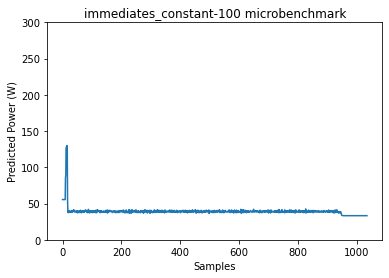

130.05682272


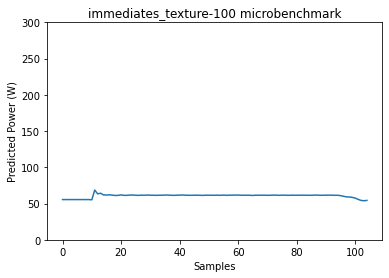

68.59552271999999


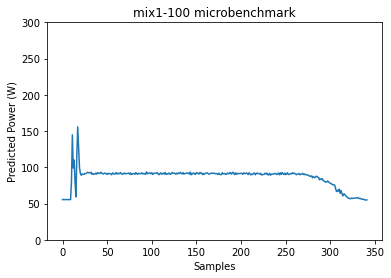

155.92322272


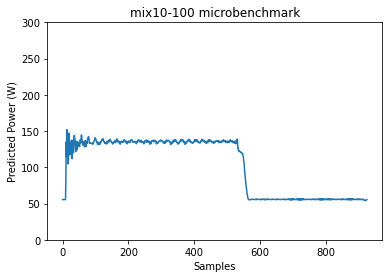

151.97022271999998


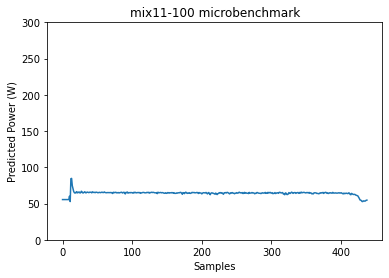

84.72852272


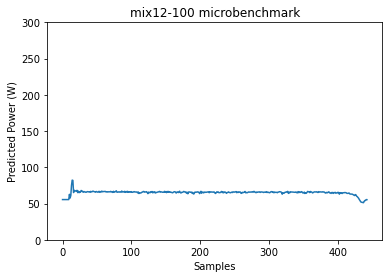

82.33012271999999


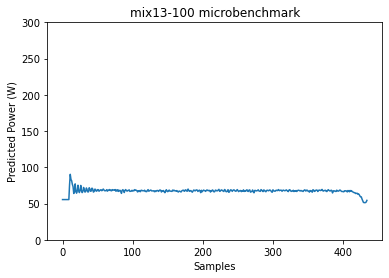

90.34292271999999


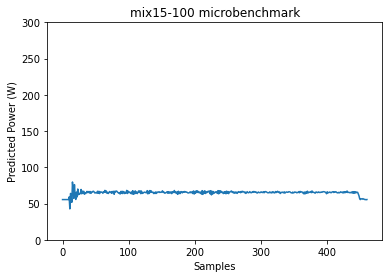

79.75662272


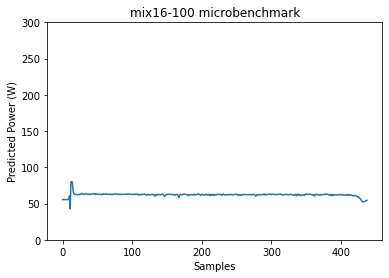

80.21852272000001


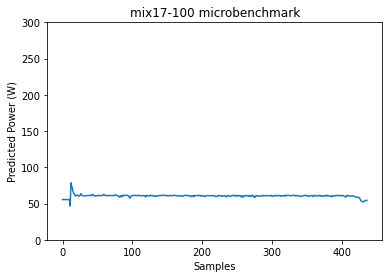

78.68492272


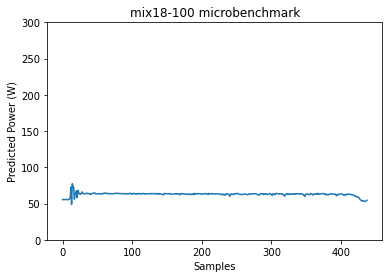

77.36672272


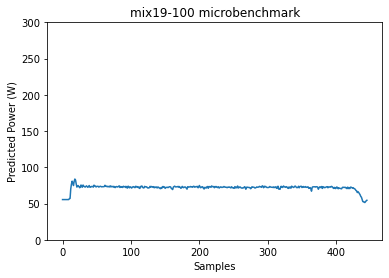

83.80742272


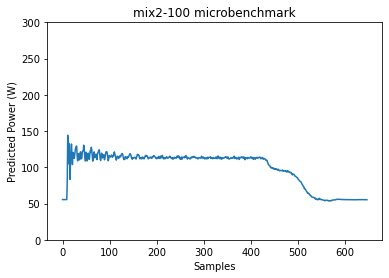

144.29022272


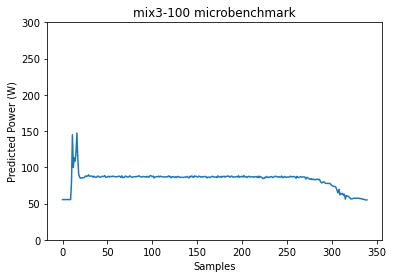

147.23822272


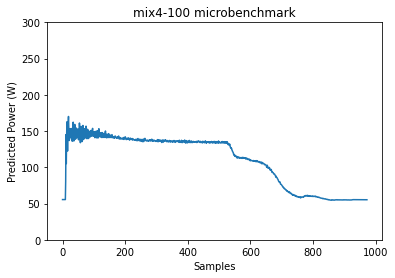

170.15722272


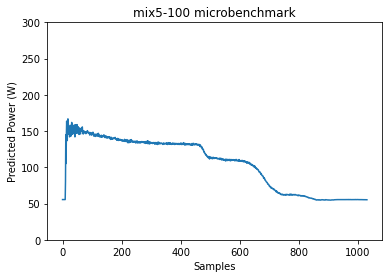

166.83522272


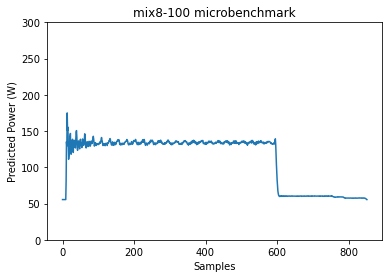

175.03122272


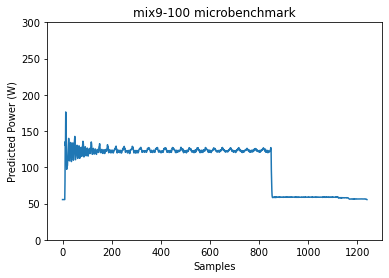

176.37322272


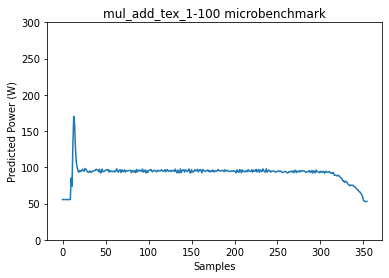

170.34822272


In [60]:
#Let's just plot the power profile
target_benchmark = 'TENSOR-100'
for target_benchmark in plotting_dict:
    data = plotting_dict[target_benchmark]

    plt.plot(data)
    plt.title(f'{target_benchmark} microbenchmark')
    plt.xlabel('Samples')
    plt.ylabel('Predicted Power (W)')
    plt.ylim(0,300)
    plt.show()
    print(max(data))

In [ ]:
#Now for the energy per instruction handwave!

for benchmark,kernel,cycle_count,instr_count,df in kernel_info_list:
    total_energy,dyn_energy,static_energy,_= energy_dict[benchmark]
    key = f"{benchmark}_{kernel}".replace('-','_')
    #we only care about the benchmarks that are in the ground truth
    if key in ground_truth_instr_count_dict:
        ground_truth = ground_truth_instr_count_dict[key]
        #Now we calculated the energy per opcode
        #How exactly do I want to do this?
        #Is it access based? Is it something else?
        #I don't really know
